# can the temperature along line P be used as a signal for the location of the split between the Alaska Gyre and CCS?
I feel like the location is not just connected to NPGO.. so perhaps this is a more straightforward way?

In [53]:
import xarray as xr
import pandas as pd
import numpy as np
import cmocean
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import griddata
import datetime as dt
from matplotlib.gridspec import GridSpec

In [2]:
meta= pd.read_csv('/ocean/rbeutel/MOAD/analysis-becca/Ariane/lineP.txt',delimiter='\t') # line p metadata
slat = [float(lat[:2])+float(lat[3:5])/60+float(lat[-1])/3600 for lat in meta['lat']]   # latitude of the stations from 1-26 (station papa)
slon = [float(lon[:3])+float(lon[4:6])/60+float(lon[-1])/3600 for lon in meta['lon']]   # longitude of the stations from 1-26 (station papa)


In [3]:
d = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/NPCbifurcation/IOS_CTD_Profiles_0386_60fb_a8ca.nc')
df = d.to_dataframe()

In [4]:
# list all the project names
# (np.array(list(set(df.project))))[250:]

In [5]:
len(df[(df.project=='Station P')|(df.project=='Line P')|(df.project=='Line P, JGOFS')|
   (df.project=='Line P/Series-Solas')|(df.project=='LIne P')|(df.project=='Line P & Chatham Sound')
   |(df.project=='Line P, Eddies')|(df.project=='Line P/Line R/ Hecate Strait')
   |(df.project=='Line P, WOCE, JGOFS')|(df.project=='Line P, WOCE P15N')])

587588

In [6]:
len(df[(df.project=='Station P')|(df.project=='Line P')|(df.project=='LIne P')])
# will stick with this for now bc i'm not sure about what the other words mean in the project name
# and the number of obs does not change significantly

516419

In [7]:
# also just gonna look at the top 50 m according to Crawford et al., 2007
df = df[(df.project=='Station P')|(df.project=='Line P')|(df.project=='LIne P')]
df = df[df.depth <= 50]

In [8]:
# Calculate the nearest station for each data point (based on longitude since latitude varies little)
def find_nearest_station_names(station_longitudes, data_longitudes, station_names):
    nearest_station_names = []  # Use a list to store station names
    nearest_station_lons = []  # Use a list to store station names

    
    for data_lon in data_longitudes:
        differences = np.abs(station_longitudes - data_lon)
        nearest_station_idx = np.argmin(differences)
        nearest_station_name = station_names[nearest_station_idx]
        nearest_station_names.append(nearest_station_name)
        
        # nearest_station_lon = station_longitudes[nearest_station_idx]
        nearest_station_lons.append(station_longitudes[nearest_station_idx])
    
    return nearest_station_names, nearest_station_lons

In [9]:
station, lon = find_nearest_station_names(np.array(slon)*-1,df.longitude,meta.station)
df['station'] = station
df['station_lon'] = lon

In [10]:
dfavg= df.groupby(['station', 'time']).agg({
    'sea_water_temperature': 'mean',
    'sea_water_practical_salinity': 'mean',
    # For other columns, decide how to aggregate. Here are some examples:
    'latitude': 'first',
    'longitude': 'first',
    'station_lon': 'first',
}).reset_index()

dfavg['time'] = pd.to_datetime(dfavg['time'])

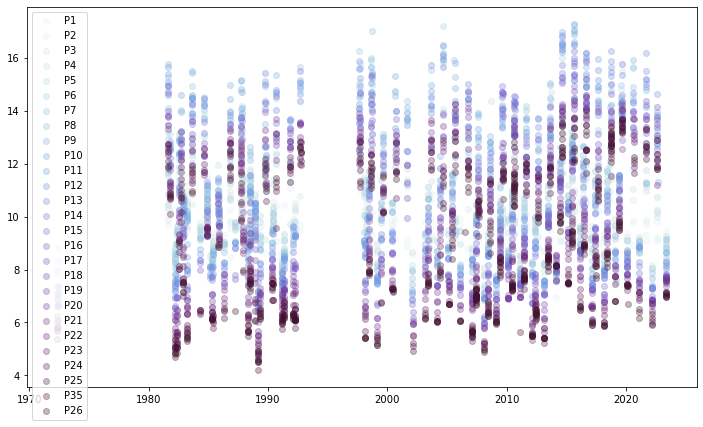

In [13]:
# plot a timeseries for each station!

# to ploat accorinding to a colormap
cmap = cmocean.cm.dense
norm = plt.Normalize(1, 27)

fig, ax = plt.subplots(1,1,figsize=(12,7))

k=0
for st in meta.station:
    color = cmap(norm(k))
    k+=1
    ax.scatter(dfavg.time[dfavg.station==st],dfavg.sea_water_temperature[dfavg.station==st],label=st,color=color,alpha=0.3)
ax.legend()

# ax.set_xlim([pd.to_datetime('2000-01-01 00:00:00'),pd.to_datetime('2005-01-01 00:00:00')]) # zooming in shows the seasonal bias
# ie. some years have multiple cruises while others only have one, so taking a simple average isn't gonna cut it

In [14]:
# what if we looked at the year average?
dfavg['year'] = dfavg['time'].dt.year

yearly = dfavg.groupby(['station', 'year']).agg({
    'sea_water_temperature': 'mean',
    'sea_water_practical_salinity': 'mean',
    'latitude': 'mean',
    'longitude': 'mean',
    'station_lon': 'mean',

}).reset_index()

(1995.0, 2023.0)

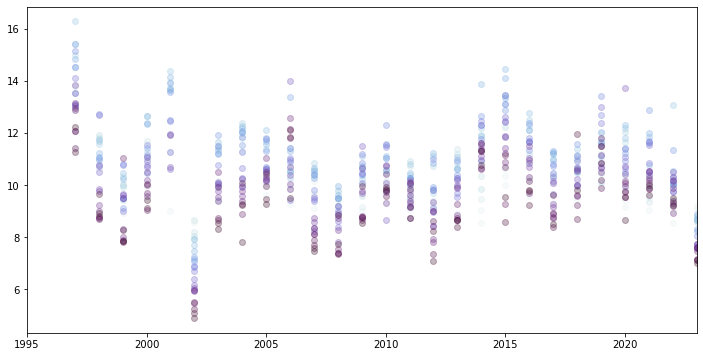

In [15]:
# plot a timeseries for each station!

# to ploat accorinding to a colormap
cmap = cmocean.cm.dense
norm = plt.Normalize(1,27)

fig, ax = plt.subplots(1,1,figsize=(12,6))

k =0
for st in meta.station:
    color = cmap(norm(k))
    k+=1
    ax.scatter(yearly.year[yearly.station==st],yearly.sea_water_temperature[yearly.station==st],label=st,color=color,alpha=0.3)
# ax.legend()

ax.set_xlim([1995,2023])

In [16]:
# lets separate into seasons
dfavg['month'] = dfavg['time'].dt.month

spri = dfavg[(dfavg.month>=3)&(dfavg.month<=5)]
summ = dfavg[(dfavg.month>=6)&(dfavg.month<=8)]
fall = dfavg[(dfavg.month>=9)&(dfavg.month<=11)]
wint = dfavg[(dfavg.month==12)|(dfavg.month==1)|(dfavg.month==2)]


Text(0.5, 1.0, 'Fall')

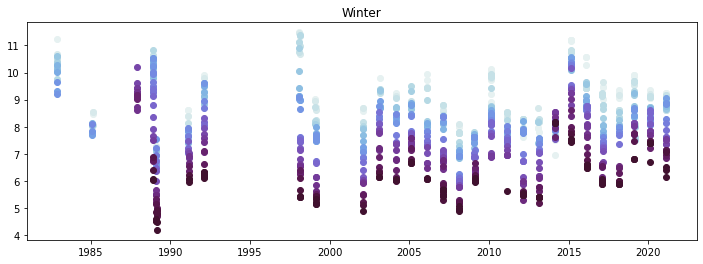

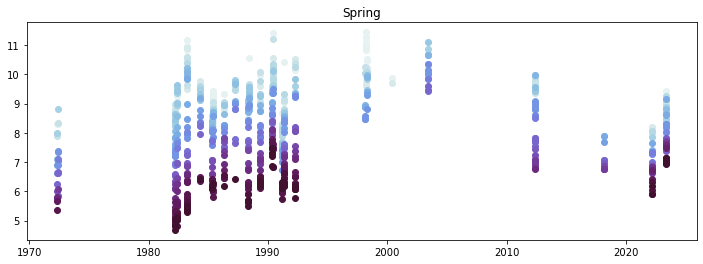

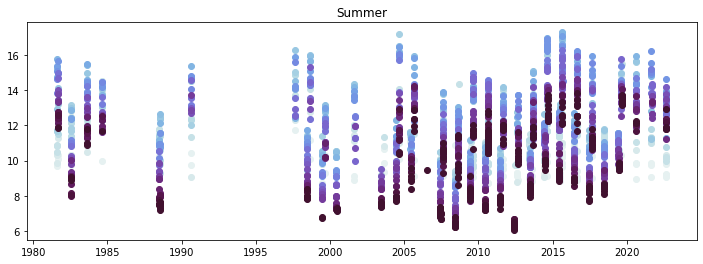

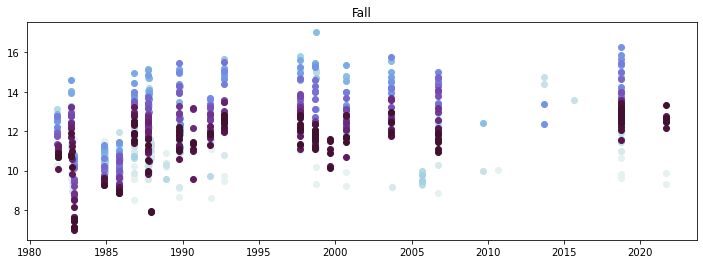

In [17]:
# plot a timeseries for each station!
# to ploat accorinding to a colormap
cmap = cmocean.cm.dense
norm = plt.Normalize(1,27)

#winter
data = wint
fig, ax = plt.subplots(1,1,figsize=(12,4))

k =0
for st in meta.station:
    color = cmap(norm(k))
    k+=1
    ax.scatter(data.time[data.station==st],data.sea_water_temperature[data.station==st],label=st,color=color)
ax.set_title('Winter')

#Spring
data = spri
fig, ax = plt.subplots(1,1,figsize=(12,4))

k =0
for st in meta.station:
    color = cmap(norm(k))
    k+=1
    ax.scatter(data.time[data.station==st],data.sea_water_temperature[data.station==st],label=st,color=color)
ax.set_title('Spring')

#Summer
data = summ
fig, ax = plt.subplots(1,1,figsize=(12,4))

k =0
for st in meta.station:
    color = cmap(norm(k))
    k+=1
    ax.scatter(data.time[data.station==st],data.sea_water_temperature[data.station==st],label=st,color=color)
ax.set_title('Summer')

#Fall
data = fall
fig, ax = plt.subplots(1,1,figsize=(12,4))

k =0
for st in meta.station:
    color = cmap(norm(k))
    k+=1
    ax.scatter(data.time[data.station==st],data.sea_water_temperature[data.station==st],label=st,color=color)
ax.set_title('Fall')

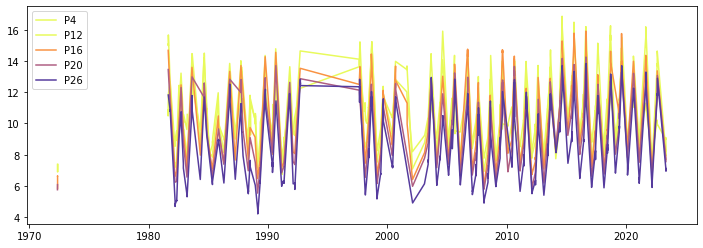

In [18]:
# lets just look at a few stations
subset = ['P4','P12','P16','P20','P26']

# to ploat accorinding to a colormap
cmap = cmocean.cm.thermal_r
norm = plt.Normalize(1, len(subset))

fig, ax = plt.subplots(1,1,figsize=(12,4))

k=0
for st in subset:
    color = cmap(norm(k))
    k+=1
    ax.plot(dfavg.time[dfavg.station==st],dfavg.sea_water_temperature[dfavg.station==st],label=st,color=color)
ax.legend()

In [19]:
dfavg.set_index('time', inplace=True)

In [20]:
# Assuming 'df' is your DataFrame with columns 'datetime', 'station', 'temperature'
# and 'datetime' is already set as the DataFrame index
# If 'datetime' is not the index, set it with: df.set_index('datetime', inplace=True)

# Filter the data for each station
station1 = 'P26'  # Replace with your actual station name
station2 = 'P20'  # Replace with your actual station name

df26 = dfavg[dfavg['station'] == 'P26']
df20 = dfavg[dfavg['station'] == 'P20']
df16 = dfavg[dfavg['station'] == 'P16']
df12 = dfavg[dfavg['station'] == 'P12']
df4 = dfavg[dfavg['station'] == 'P4']


# Resample on a monthly basis
# 'M' denotes month end frequency
df26 = df26.resample('3M').mean()
df20 = df20.resample('3M').mean()
df16 = df16.resample('3M').mean()
df12 = df12.resample('3M').mean()
df4 = df4.resample('3M').mean()


# Interpolate missing values if necessary
df26.interpolate(method='linear', inplace=True)
df20.interpolate(method='linear', inplace=True)
df16.interpolate(method='linear', inplace=True)
df12.interpolate(method='linear', inplace=True)
df4.interpolate(method='linear', inplace=True)


# Ensure both DataFrames cover the same period
# This step may not be necessary if you're confident both stations cover identical periods
common_index = df12.index.intersection(df20.index)
df26 = df26.loc[common_index]
df20 = df20.loc[common_index]
df16 = df16.loc[common_index]
df12 = df12.loc[common_index]
df4 = df4.loc[common_index]


# Calculate the temperature difference
# df_temperature_difference = df20.sea_water_temperature - df26.sea_water_temperature

# df_temperature_difference now contains the monthly temperature differences

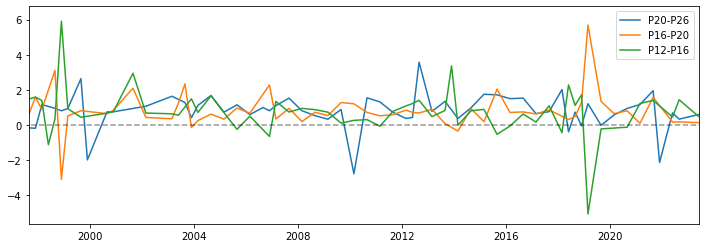

In [21]:
# temperature difference of these stations
subset = ['P4','P12','P16','P20','P26']

# to ploat accorinding to a colormap
cmap = cmocean.cm.thermal_r
norm = plt.Normalize(1, len(subset))

fig, ax = plt.subplots(1,1,figsize=(12,4))

ax.plot(common_index,df20.sea_water_temperature - df26.sea_water_temperature,label="P20-P26")
ax.plot(common_index,df16.sea_water_temperature - df20.sea_water_temperature,label="P16-P20")
ax.plot(common_index,df12.sea_water_temperature - df16.sea_water_temperature,label="P12-P16")
# ax.scatter(common_index,df4.sea_water_temperature - df12.sea_water_temperature,label="P4-P12")
ax.plot([common_index[0],common_index[-1]],[0,0],'k--',alpha=0.4)
ax.set_xlim([common_index[116],common_index[-1]])

ax.legend()

In [22]:
dfavg['monthday']=[pd.to_datetime(str(dfavg.month[i])+"/1/"+str(dfavg.year[i])) for i in range(len(dfavg))]

In [23]:
monthly = dfavg.groupby(['station', 'monthday']).agg({
    'sea_water_temperature': 'mean',
    'sea_water_practical_salinity': 'mean',
    'latitude': 'mean',
    'longitude': 'mean',
    'station_lon': 'mean',

}).reset_index()

# Pivot the DataFrame to create the grid
temperature_grid = dfavg.pivot_table(index='monthday', columns='station_lon', values='sea_water_temperature', aggfunc='mean')

In [24]:
temperature_grid

station_lon,-145.000000,-144.300556,-143.600833,-142.666667,-141.666667,-140.666667,-139.666667,-138.666667,-137.666667,-136.666667,...,-129.666667,-129.166667,-128.666667,-128.166667,-127.666667,-127.166667,-126.666667,-126.333333,-126.000000,-125.500000
monthday,,,,,,,,,,,,,,,,,,,,,
1972-05-01,NaN,NaN,5.362713,5.683036,NaN,5.810106,NaN,5.916131,NaN,6.000960,...,NaN,NaN,7.106866,NaN,8.415203,NaN,8.109267,NaN,8.119600,8.297565
1981-08-01,11.827802,12.251717,12.592237,12.386833,12.693494,12.501060,13.304887,13.461090,13.781773,14.014922,...,13.631974,15.362080,15.276981,13.518232,12.444204,11.634884,11.021533,10.475040,10.247199,9.998502
1981-10-01,10.817848,NaN,10.375673,10.778315,11.123568,11.150371,11.297149,11.192981,11.124371,11.350845,...,12.536645,12.854797,11.991523,11.978649,12.001247,12.853226,12.688200,11.852031,11.044250,10.264537
1982-03-01,4.897716,4.929366,5.146833,5.330015,5.416945,5.786023,6.079208,6.235680,6.106339,6.369785,...,7.608148,7.512178,7.809165,8.290005,8.380968,8.358236,8.703347,8.792894,8.833782,8.257381
1982-05-01,5.050906,5.032382,5.251436,5.528419,5.645527,6.012185,6.261811,6.282375,6.463508,6.457313,...,7.966931,8.187815,8.573922,9.352998,9.272422,8.852931,9.213779,9.225737,9.250251,9.471109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,NaN,NaN,NaN,NaN,13.312052,13.397827,13.276415,12.564973,13.675319,13.683033,...,15.153075,14.798646,12.802776,11.223666,11.270214,11.779310,11.136260,11.313770,9.794470,9.092438
2021-09-01,12.738301,12.169235,12.641832,12.774202,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.892467,9.320448
2022-03-01,6.000134,6.312922,6.036418,6.420712,6.739468,6.685268,6.837590,6.691182,6.869669,6.831467,...,7.479794,7.425166,7.310673,NaN,7.867342,8.073162,8.053810,8.181752,7.881116,7.933018


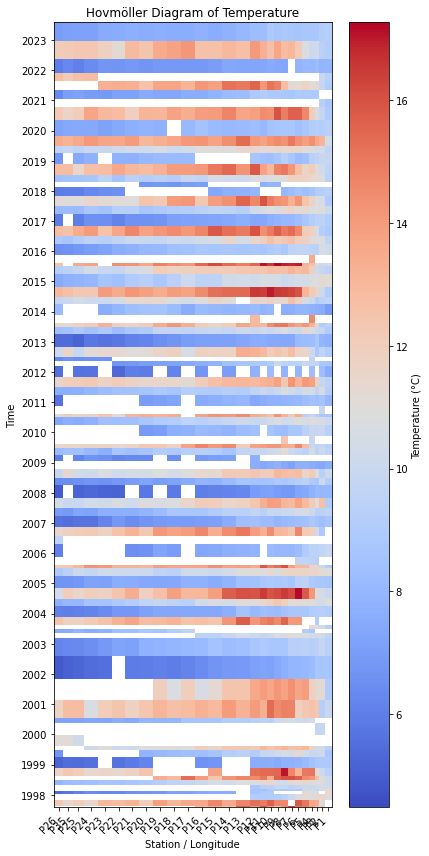

In [25]:
# wait a hovmoler diagram would be a WAY better way to plot this info

import matplotlib.dates as mdates

# Prepare the figure and axis
fig, ax = plt.subplots(figsize=(6, 12))

# # The stations might be non-numeric, so we need an array of station indices for plotting
# station_indices = np.arange(len(temperature_grid.columns))

# # Convert the station names to strings, in case they're not
# station_names = temperature_grid.columns.astype(str)

# Plotting
c = ax.pcolormesh(temperature_grid.columns, temperature_grid.index, temperature_grid.values, shading='auto', cmap='coolwarm')

# Formatting the x-axis to show station names
ax.set_xticks(np.array(slon)*-1)
ax.set_xticklabels(meta.station, rotation=45, ha="right")

# Formatting the y-axis to show dates
ax.yaxis_date()  # Ensure the y-axis treats dates as such
ax.yaxis.set_major_locator(mdates.YearLocator())  # Tick every year
ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Show year only

# Adding labels and title
ax.set_xlabel('Station / Longitude')
ax.set_ylabel('Time')
ax.set_title('Hovmöller Diagram of Temperature')

# Add a colorbar
fig.colorbar(c, ax=ax, label='Temperature (°C)')

# trim to 1998
ax.set_ylim([pd.to_datetime('8/1/1997'),pd.to_datetime('8/1/2023')])

plt.tight_layout()
plt.show()


In [27]:
# try a linear interpolation
# Create meshgrids for original station indices and dates
station_indices = temperature_grid.columns
station_indices_mesh, dates_mesh = np.meshgrid(station_indices, mdates.date2num(temperature_grid.index))

# Flatten the meshgrids and the temperature values for input to griddata
points = np.column_stack((station_indices_mesh.ravel(), dates_mesh.ravel()))
values = temperature_grid.values.ravel()

# Identify rows in 'values' that are not NaN
valid = ~np.isnan(values)

# Filter out rows where 'values' are NaN
points_valid = points[valid]
values_valid = values[valid]

# Define the grid to interpolate on - this can be the same as your original grid or finer
grid_x, grid_y = station_indices_mesh, dates_mesh#np.meshgrid(station_indices, np.linspace(dates_mesh.min(), dates_mesh.max(), len(temperature_grid.index)))

# Perform the interpolation
grid_z = griddata(points_valid, values_valid, (grid_x, grid_y), method='linear')  # Consider 'cubic' for smoother results

# Now, grid_x and grid_y are your interpolated coordinates, and grid_z contains interpolated temperatures


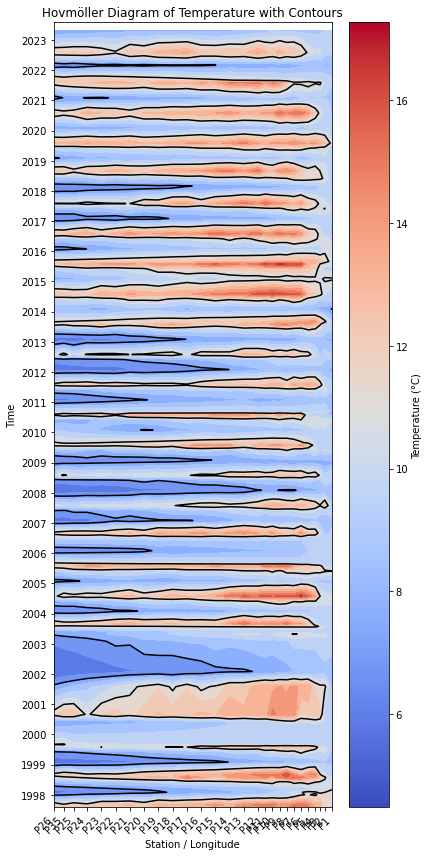

In [28]:
fig, ax = plt.subplots(figsize=(6, 12))

# Assuming temperature_grid is your pivoted DataFrame prepared as before
# station_indices = temperature_grid.columns
# station_names = temperature_grid.columns.astype(str)  # Ensure station names are strings

# Create a meshgrid for the contour plot
# X-axis: station indices, Y-axis: dates
X, Y = np.meshgrid(grid_x,grid_y)

# Plot the temperature data with pcolormesh
# c = ax.pcolormesh(X, Y, temperature_grid.values, shading='auto', cmap='coolwarm')

# Add contour lines over the pcolormesh
# Note: Adjust levels as needed to fit your data
CS = ax.contourf(grid_x, grid_y, grid_z, cmap='coolwarm', levels=np.arange(4, 19, 1))
ax.contour(grid_x, grid_y, grid_z, colors =['k','k'], levels=[7,11])

# Formatting the x-axis to show station names
ax.set_xticks(np.array(slon)*-1)
ax.set_xticklabels(meta.station, rotation=45, ha="right")

# Formatting the y-axis for dates
ax.yaxis_date()
ax.yaxis.set_major_locator(mdates.YearLocator())
ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax.set_xlabel('Station / Longitude')
ax.set_ylabel('Time')
ax.set_title('Hovmöller Diagram of Temperature with Contours')

# trim to 1998
ax.set_ylim([pd.to_datetime('8/1/1997'),pd.to_datetime('8/1/2023')])

# Add a colorbar for the pcolormesh
fig.colorbar(c, ax=ax, label='Temperature (°C)')

plt.tight_layout()
plt.show()

In [54]:
# lets get the NPGO timeseries
npgo = pd.read_csv('NPGO.txt',header=25,delimiter='  ',).drop(
    axis=1, labels=['YEAR','Unnamed: 4','Unnamed: 5','Unnamed: 6','Unnamed: 7','Unnamed: 8','MONTH','Unnamed: 10','Unnamed: 11','Unnamed: 12','NPGO index']).rename(
    columns={"#":"year","Unnamed: 1":"month","Unnamed: 2":"ind"});

npgo['date'] = [dt.datetime(int(npgo.year[i]),int(npgo.month[i]),1) for i in range(len(npgo))]

<ipython-input-54-39b3f8124496>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  npgo = pd.read_csv('NPGO.txt',header=25,delimiter='  ',).drop(


In [114]:
# and the MEI timeseries

df = pd.read_csv('meiv2.data',header=3,delimiter='    ')

for col in df.columns[1:]:  # Skip the first column 'Year'
    df[col] = pd.to_numeric(df[col], errors='coerce')

mei = df.iloc[:, 1:].to_numpy().flatten()

# Creating the date range
start_year = df['YEAR'].iloc[0]  # First year in your data
total_months = len(mei)  # Total number of data points
start_date = f"{start_year}-01-01"  # Assuming January is the first month

# Generate the date range, setting frequency to 'MS' (month start)
meidates = pd.date_range(start=start_date, periods=total_months, freq='MS')

<ipython-input-114-c171a953f67b>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('meiv2.data',header=3,delimiter='    ')


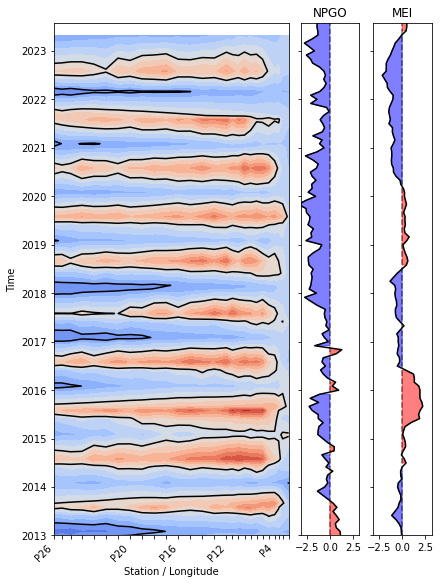

In [118]:
# trim to dates you care about and add timeseries of MEI and NPGO strength next to it
l=6
fig = plt.figure(constrained_layout=True, figsize=[l,8])
gs = GridSpec(1, l, figure=fig)
ax0 = fig.add_subplot(gs[0, :(l-2)])
ax1 = fig.add_subplot(gs[0, (l-2)])
ax2 = fig.add_subplot(gs[0, (l-1)])

############
# Hovmoler #
############
# Create a meshgrid for the contour plot
X, Y = np.meshgrid(grid_x,grid_y)

# Add contour lines over the pcolormesh
# Note: Adjust levels as needed to fit your data
CS = ax0.contourf(grid_x, grid_y, grid_z, cmap='coolwarm', levels=np.arange(4, 19, 1))
ax0.contour(grid_x, grid_y, grid_z, colors =['k','k'], levels=[7,11])

# Formatting the x-axis to show station names
ax0.set_xticks(np.array(slon)*-1)
ax0.set_xticklabels(['P26','','','','','','','P20','','','','P16','','','','P12','','','','','','','','P4','','',''][::-1], rotation=45, ha="right")

# Formatting the y-axis for dates
ax0.yaxis_date()
ax0.yaxis.set_major_locator(mdates.YearLocator())
ax0.yaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax0.set_xlabel('Station / Longitude')
ax0.set_ylabel('Time')
# ax.set_title('Hovmöller Diagram of Temperature with Contours')

# trim to 2013
ax0.set_ylim([pd.to_datetime('1/1/2013'),pd.to_datetime('8/1/2023')])

# Add a colorbar for the pcolormesh
# fig.colorbar(c, ax=ax0, label='Temperature (°C)')

# plt.tight_layout()
# plt.show()


########
# NPGO #
########
ax1.set_xlim([-3.2,3.2])
ax1.set_ylim([pd.to_datetime('1/1/2013'),pd.to_datetime('8/1/2023')])
ax1.plot(npgo.ind,npgo.date,'k')
ax1.plot([0,0],[pd.to_datetime('1/1/2013'),pd.to_datetime('8/1/2023')],'k--',alpha=0.5)
ax1.set_yticklabels([])
ax1.fill_betweenx(npgo.date, npgo.ind, 0, where=(npgo.ind > 0), color='red', alpha=0.5, label='Positive')
ax1.fill_betweenx(npgo.date, npgo.ind, 0, where=(npgo.ind < 0), color='blue', alpha=0.5, label='Negative')
ax1.set_title("NPGO")

#######
# MEI #
#######
ax2.set_xlim([-3.2,3.2])
ax2.set_ylim([pd.to_datetime('1/1/2013'),pd.to_datetime('8/1/2023')])
ax2.plot(mei,meidates,'k')
ax2.plot([0,0],[pd.to_datetime('1/1/2013'),pd.to_datetime('8/1/2023')],'k--',alpha=0.5)
ax2.set_yticklabels([])
ax2.set_title("MEI")
ax2.fill_betweenx(meidates, mei, 0, where=(mei > 0), color='red', alpha=0.5, label='Positive')
ax2.fill_betweenx(meidates, mei, 0, where=(mei < 0), color='blue', alpha=0.5, label='Negative')



In [86]:
npgo.ind

0     -2.188395
1     -1.445831
2     -0.965036
3     -0.858788
4     -0.634082
         ...   
884   -1.755664
885   -1.091992
886   -1.851244
887   -1.911167
888   -0.357338
Name: ind, Length: 889, dtype: float64

In [76]:
from scipy.interpolate import CloughTocher2DInterpolator
import numpy as np

# Flatten your X, Y coordinates and temperature values
x = station_indices_mesh.ravel()  # Longitude or station index
y = mdates.date2num(temperature_grid.index).repeat(len(station_indices))  # Convert dates to numeric format and repeat for each station
values = temperature_grid.values.ravel()  # Temperature values

# Combine x and y into a single array of points
points = np.vstack([x, y]).T

# Identify rows in 'values' that are not NaN
valid = ~np.isnan(values)

# Filter out rows where 'values' are NaN
points_valid = points[valid]
values_valid = values[valid]

In [77]:
# Create the interpolator object
interpolator = CloughTocher2DInterpolator(points_valid, values_valid, fill_value=np.nan)

# Define the interpolation grid
# It's essential to match this grid to the dimensions you're plotting
grid_x, grid_y = np.meshgrid(np.sort(np.unique(x)), np.sort(np.unique(y)))

# Perform the interpolation
grid_z = interpolator(grid_x, grid_y)

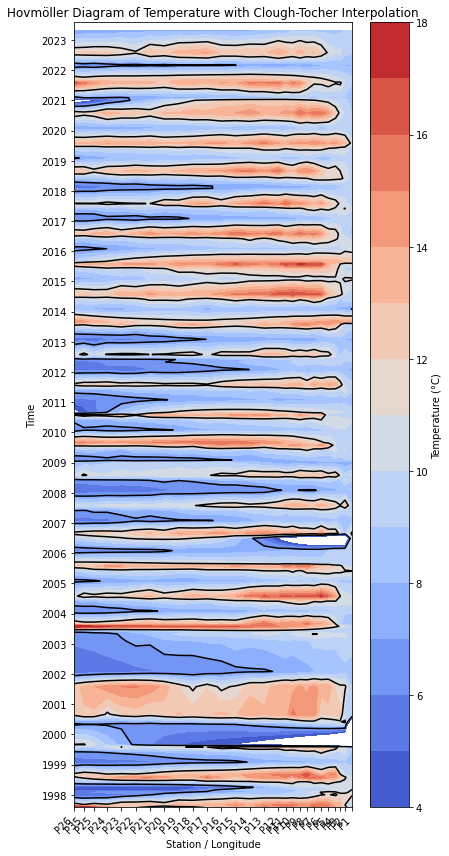

In [80]:
# Make sure to convert the numeric dates back to datetime for plotting
dates = mdates.num2date(grid_y[:, 0])  # Only need to convert the first column back to datetime

fig, ax = plt.subplots(figsize=(6, 12))

# Plotting the interpolated data
CS = ax.contourf(grid_x, grid_y, grid_z, cmap='coolwarm', levels=np.arange(4, 19, 1))
ax.contour(grid_x, grid_y, grid_z, colors=['k', 'k'], levels=[7, 11])

# Set the x-ticks if necessary
ax.set_xticks(np.array(slon) * -1)  # Assuming 'slon' is your stations' longitude array
ax.set_xticklabels(meta.station, rotation=45, ha="right")  # Assuming 'meta.station' holds station names

# Formatting the y-axis for dates
ax.yaxis_date()
ax.yaxis.set_major_locator(mdates.YearLocator())
ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Labels, title, and colorbar
ax.set_xlabel('Station / Longitude')
ax.set_ylabel('Time')
ax.set_title('Hovmöller Diagram of Temperature with Clough-Tocher Interpolation')
fig.colorbar(CS, ax=ax, label='Temperature (°C)')

# trim to 1998
ax.set_ylim([pd.to_datetime('8/1/1997'),pd.to_datetime('8/1/2023')])

plt.tight_layout()
plt.show()